In [1]:
import gymnasium as gym

from stable_baselines3 import SAC, DDPG, PPO


from environment import *
from env_wrappers import *
from matplotlib import pyplot as plt
from general_utils import *
from delay_model import *
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise
import torch
from wc_sac import *
from stable_baselines3.common.logger import Logger, configure
import datetime
import copy
from test_utils import *
from train_utils import *
from orchestrator import *
import pandas as pd
from safe_sac import SafeSAC

%load_ext autoreload
%autoreload 2

plt.rcParams['font.family'] = 'serif'

## Spherical tank with state and error

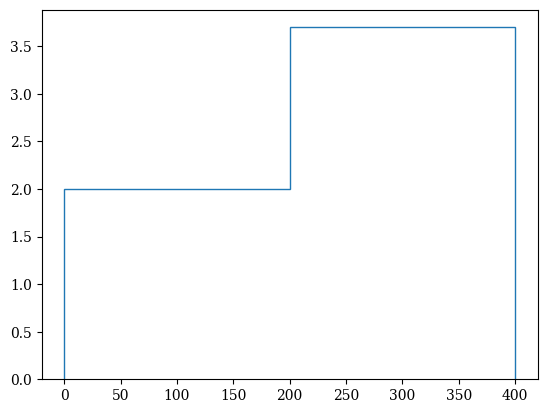

In [7]:
core_env = SphericalTank(desired_state=np.array([ 2.0, 3.7]), max_episode_len=400)
plt.stairs(core_env.desired_trajectory)

In [24]:
core_env = SphericalTank(desired_state=np.array([2.0]), max_episode_len=100)
tank_agent, tank_env = train_default_sac(core_env = core_env, desired_state=2.0, seed = 42, n_episodes = 50, observation_type='error')



Wrapping in observe error
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/SphericalTank/error/0522/Desired2.0/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -53      |
| time/              |          |
|    episodes        | 4        |
|    fps             | 34       |
|    time_elapsed    | 11       |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 0.103    |
|    critic_loss     | 0.00397  |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -43.2    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 31       |
|    time_elapsed    | 25       |
| 

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\SphericalTank\error\Desired2.0' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


Initial state was [-2.14441103]


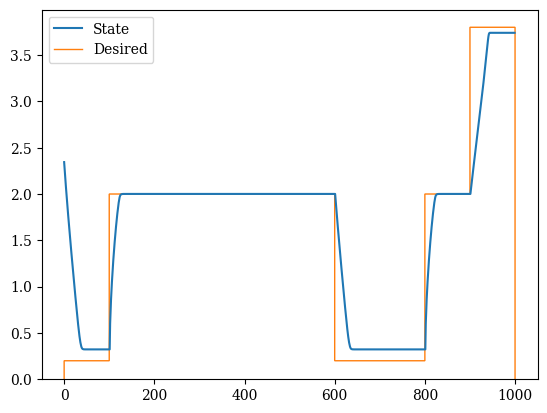

In [59]:
test_env = copy.deepcopy(tank_env)
test_env.unwrapped.max_episode_len = 1000
test_env.unwrapped.desired_trajectory = get_setpoint_trajectory([2.0, 0.2, 3.8], 1000, steps_per_change=100)

states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)
plt.plot((np.array(states)))
plt.stairs(np.array(test_env.unwrapped.desired_trajectory).reshape(-1,))
plt.legend(['State', 'Desired'])

## Training with randomised states

In [135]:
core_env = SphericalTank(desired_state=np.array([2.2]), max_episode_len=100)
tank_agent, tank_env = train_default_sac(core_env = core_env, desired_state=2.2, seed = 42, n_episodes = 100, observation_type='state-error', randomise_setpoint=True)

Wrapping in random setpoint
Wrapping in observe state error
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/SphericalTank/state-error/randomised/0522/Desired2.2/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -183     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 43       |
|    time_elapsed    | 9        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 2.35     |
|    critic_loss     | 0.0668   |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -121     |
| time/              |          |
|    episodes        | 8        |
|    fps           

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\SphericalTank\state-error\randomised\Desired2.2' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [74]:
tank_env.reset()
print(f"State and error {tank_env.state}, {tank_env.error} for desired {tank_env.desired_state}")

State and error [2.89777185], [-1.55716213] for desired [1.34060972]


Initial state was [-0.01735078  0.50867539]


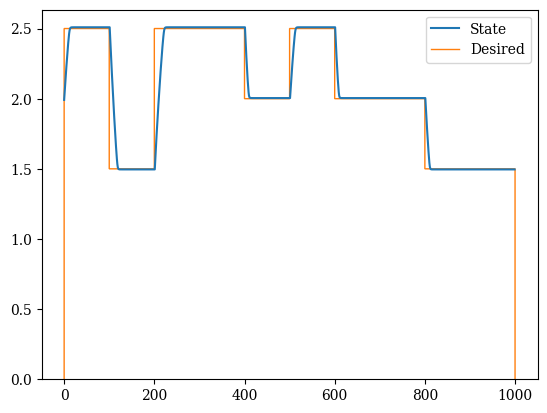

In [137]:
test_env = copy.deepcopy(tank_env)
test_env.start_state = np.array([2.0])
test_env.unwrapped.max_episode_len = 1000
test_env.unwrapped.desired_trajectory = get_setpoint_trajectory([1.5, 2.0, 2.5], 1000, steps_per_change=100)


states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)
plt.plot((np.array(states)))
plt.stairs(np.array(test_env.unwrapped.desired_trajectory).reshape(-1,))
# plt.plot(np.ones(100)*test_env.desired_state, linestyle='--')
plt.legend(['State', 'Desired'])

In [113]:
print(tank_agent.actor)

Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (latent_pi): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=256, out_features=1, bias=True)
  (log_std): Linear(in_features=256, out_features=1, bias=True)
)


## Rescaled, smaller range

In [139]:
core_env = SphericalTank(desired_state=np.array([3.2]), max_episode_len=100)
tank_agent, tank_env = train_default_sac(core_env = core_env, desired_state=3.2, seed = 42, n_episodes = 100, observation_type='state-error', randomise_setpoint=True)

Wrapping in random setpoint
Wrapping in observe state error
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/SphericalTank/state-error/randomised/0522/Desired3.8/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -362     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 32       |
|    time_elapsed    | 12       |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 7.08     |
|    critic_loss     | 1.39     |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -463     |
| time/              |          |
|    episodes        | 8        |
|    fps           

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\SphericalTank\state-error\randomised\Desired3.8' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [190]:
test_env = copy.deepcopy(tank_env)
test_env.start_state = np.array([2.0])
test_env.unwrapped.max_episode_len = 1000
test_env.unwrapped.desired_trajectory = get_setpoint_trajectory([3.5, 3.7, 3.9], 1000, steps_per_change=100)


states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)


Initial state was [-0.47233713  0.66116857]


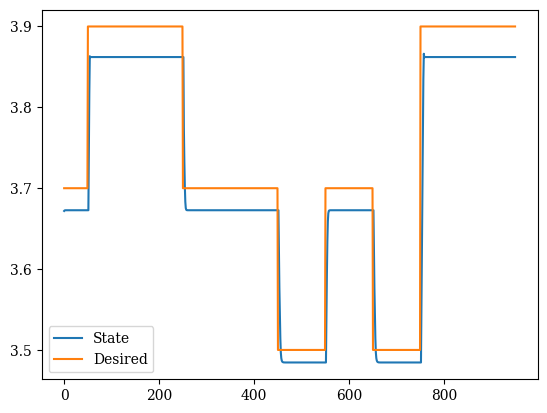

In [192]:
start = 50
end = 1000
plt.plot((np.array(states))[start:end])
plt.plot(np.array(test_env.unwrapped.desired_trajectory).reshape(-1,)[start:end])
# plt.yticks(np.arange(4, 4, 0.5))
# plt.plot(np.ones(100)*test_env.desired_state, linestyle='--')
plt.legend(['State', 'Desired'])

### Wider range 0.1 - 3.9

In [41]:
core_env = SphericalTank(desired_state=np.array([3.95]), max_episode_len=100)
tank_agent, tank_env = train_default_sac(core_env = core_env, desired_state=3.95, seed = 42, n_episodes = 100, observation_type='setpoint-error', randomise_setpoint=False)

Wrapping in observe setpoint error
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/SphericalTank/setpoint-error/fixed/0523/Desired3.95/sac
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -1.12e+03 |
| time/              |           |
|    episodes        | 4         |
|    fps             | 36        |
|    time_elapsed    | 11        |
|    total_timesteps | 400       |
| train/             |           |
|    actor_loss      | 19.5      |
|    critic_loss     | 1.53      |
|    ent_coef        | 0.5       |
|    learning_rate   | 0.0003    |
|    n_updates       | 299       |
----------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -1.1e+03 |
| time/              |          |
|    episodes        | 8        |
|    fps             | 32    

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\stable_baselines3\common\save_util.py:284: UserWarning: Path 'models\SphericalTank\setpoint-error\fixed\Desired3.95' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


In [42]:
test_env = copy.deepcopy(tank_env)
test_env.start_state = np.array([2.0])
test_env.unwrapped.max_episode_len = 1000
test_env.unwrapped.desired_trajectory = get_setpoint_trajectory([3.95, 3.9], 1000, steps_per_change=100)


states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)


Initial state was [0.975      0.11759505]


c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(
c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.last_action to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.last_action` for environment variables or `env.get_wrapper_attr('last_action')` that will search the reminding wrappers.
  logger.warn(


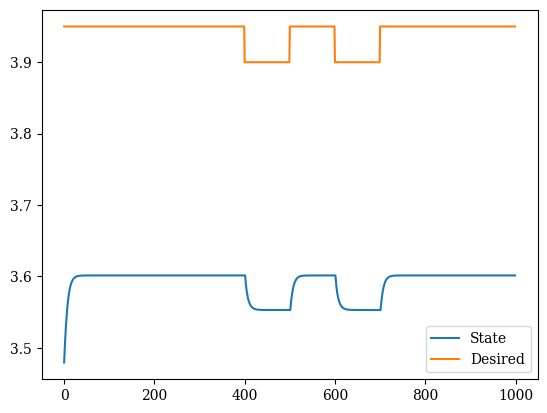

In [43]:
start = 0
end = 1000
plt.plot((np.array(states))[start:end])
plt.plot(np.array(test_env.unwrapped.desired_trajectory).reshape(-1,)[start:end])
# plt.yticks(np.arange(4, 4, 0.5))
# plt.plot(np.ones(100)*test_env.desired_state, linestyle='--')
plt.legend(['State', 'Desired'])

## Add desired state as observation

In [6]:
core_env = SphericalTank(desired_state=np.array([3.2]), max_episode_len=100)
tank_agent, tank_env = train_default_sac(core_env = core_env, desired_state=3.2, seed = 0, n_episodes = 100, observation_type='setpoint-error', randomise_setpoint=True)

Wrapping in random setpoint
Wrapping in observe setpoint error
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs/train/SphericalTank/setpoint-error/randomised/0523/Desired3.2/sac
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -266     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 45       |
|    time_elapsed    | 8        |
|    total_timesteps | 400      |
| train/             |          |
|    actor_loss      | 3.21     |
|    critic_loss     | 0.532    |
|    ent_coef        | 0.5      |
|    learning_rate   | 0.0003   |
|    n_updates       | 299      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -285     |
| time/              |          |
|    episodes        | 8        |
|    fps     

In [7]:
test_env = copy.deepcopy(tank_env)
test_env.start_state = np.array([2.0])
test_env.unwrapped.max_episode_len = 1000
test_env.unwrapped.desired_trajectory = get_setpoint_trajectory([0.2, 2.0, 3.8], 1000, steps_per_change=100)

states, actions, rewards, avg, executed = test_agent(tank_agent, test_env, deterministic=True, state_error=True)


Initial state was [ 0.         -0.05418554]


c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.state` for environment variables or `env.get_wrapper_attr('state')` that will search the reminding wrappers.
  logger.warn(


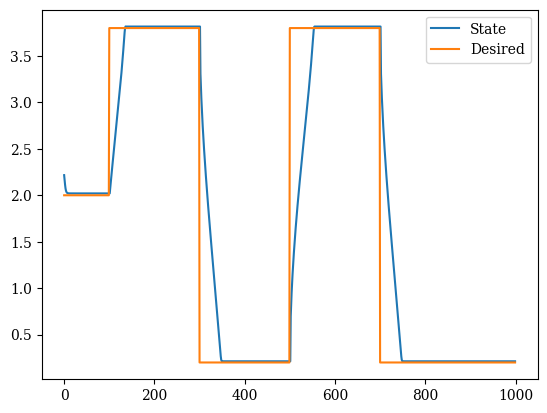

In [8]:
start =0
end = 1000
plt.plot((np.array(states))[start:end])
plt.plot(np.array(test_env.unwrapped.desired_trajectory).reshape(-1,)[start:end])
# plt.yticks(np.arange(4, 4, 0.5))
# plt.plot(np.ones(100)*test_env.desired_state, linestyle='--')
plt.legend(['State', 'Desired'])

c:\Users\seigpaw\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.desired_states_history to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.desired_states_history` for environment variables or `env.get_wrapper_attr('desired_states_history')` that will search the reminding wrappers.
  logger.warn(


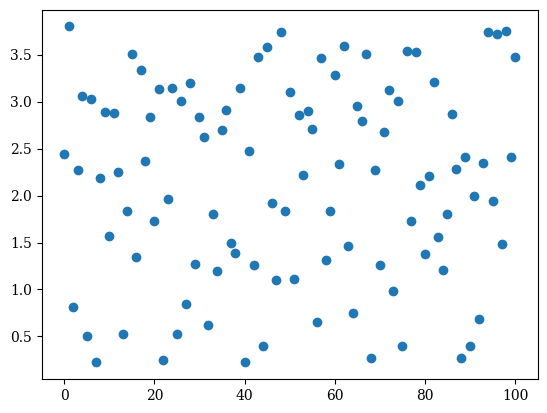

In [111]:
plt.scatter(range(len(tank_env.desired_states_history)), tank_env.desired_states_history)

# Randomised setpoint but with regions

In [62]:
env.reset()

(array([0.13696169, 0.32891003]), '')

Wrapping in random setpoint
Wrapping in observe setpoint error
(array([0, 1, 2]), array([325, 341, 334], dtype=int64))


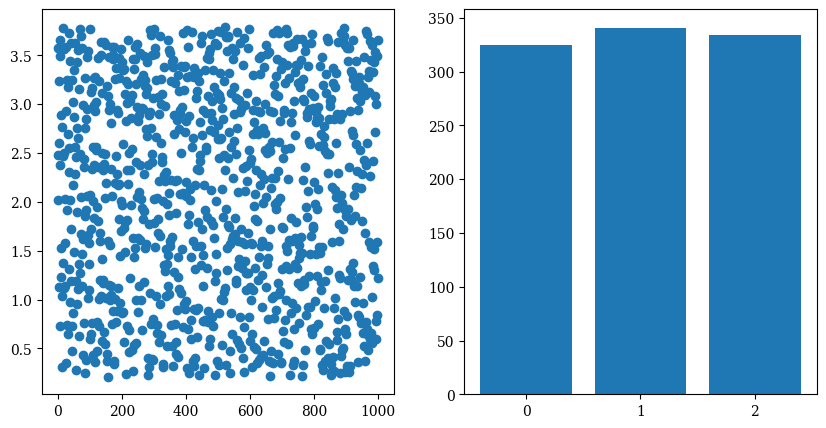

In [103]:
core_env = SphericalTank(desired_state=np.array([3.7]), max_episode_len=100, seed = 42)
env = init_wrappers(core_env, observation_type='setpoint-error', randomise_setpoint=True)
regions = []
for _ in range(1000):
    env.reset()
    # print(f"Desired {env.desired_state} and last used {env.last_used_region}")
    regions.append(env.last_used_region)

f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(range(len(env.desired_states_history)),env.desired_states_history)
# plt.scatter(range(len(regions)), regions)
region_counts = np.unique(regions, return_counts=True)
print(region_counts)

ax[1].bar(region_counts[0], region_counts[1])
ax[1].set_xticks(range(3))


In [65]:
len(env.desired_states_history)

100

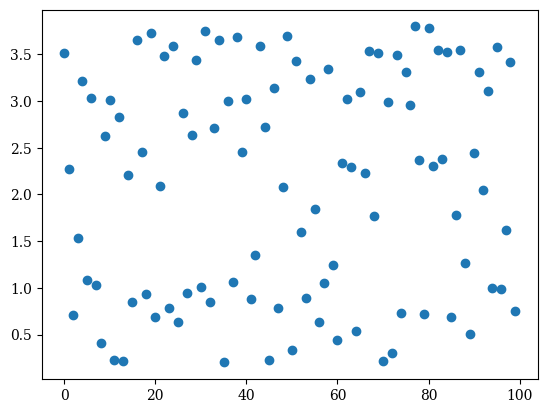

# DDPG